In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ver = 'v40_cerberus'
ab = 'TPM_allGene.tsv'
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/'


## Which samples are in the lr but not the sr?

In [3]:
df = pd.read_csv(ab, sep='\t')
df, gids = get_tpm_table(df,
                 how='sr',
                 min_tpm=1,
                 gene_subset='polya')
df = df.transpose()
print(df.shape)

df.index.name = 'dataset'
df.reset_index(inplace=True)
df.head()

Calculating short-read gene TPM values
Subsetting for polya genes


KeyError: "['wtc11_9_1', 'wtc11_9_2', 'cd14_positive_monocyte_6_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_3_1', 'cd4_positive_alpha_beta_memory_t_cell_6_1', 'cd14_positive_monocyte_5_1', 'cd8_positive_alpha_beta_memory_t_cell_5_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_2_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_1_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_1_2', 'brodmann_area_46_80_1', 'naive_b_cell_2_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_1_1', 'activated_t_cell_5_1', 'activated_t_cell_5_2', 'activated_t_cell_5_3', 'activated_t_cell_5_4', 'immature_natural_killer_cell_6_1', 'cd4_positive_alpha_beta_memory_t_cell_2_1', 'cd4_positive_alpha_beta_memory_t_cell_5_1', 'naive_b_cell_1_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_9_1', 'natural_killer_cell_1_1', 'natural_killer_cell_1_2', 'brodmann_area_46_13_1', 'activated_naive_cd4_positive_alpha_beta_t_cell_2_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_6_1', 'natural_killer_cell_5_1', 'brodmann_area_46_5_1', 'brodmann_area_46_115_1', 'brodmann_area_46_81_1', 'brodmann_area_46_104_1', 'brodmann_area_46_28_1', 'ocily7_1_1', 'ocily7_1_2', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_1_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_5_1', 'immature_natural_killer_cell_1_1', 'a549_3_1', 'a549_3_2', 'a549_3_3', 'a549_3_4', 'a549_3_5', 'brodmann_area_46_6_1', 'brodmann_area_46_57_1', 'brodmann_area_46_108_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_2_1', 'a549_6_1', 'a549_6_2', 'a549_6_3', 'a549_6_4', 'a549_6_5', 'brodmann_area_46_9_1', 'brodmann_area_46_92_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_7_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_7_2', 'brodmann_area_46_18_1', 'k562_3_1', 'k562_3_2', 'igd_negative_memory_b_cell_3_1', 'a549_2_1', 'a549_2_2', 'a549_2_3', 'a549_2_4', 'a549_2_5', 'natural_killer_cell_2_1', 'natural_killer_cell_2_2', 'natural_killer_cell_2_3', 'natural_killer_cell_2_4', 'natural_killer_cell_2_5', 'natural_killer_cell_2_6', 'natural_killer_cell_2_7', 'natural_killer_cell_2_8', 'natural_killer_cell_2_9', 'natural_killer_cell_2_10', 'brodmann_area_46_70_1', 'brodmann_area_46_88_1', 'brodmann_area_46_69_1', 't_helper_17_cell_1_1', 'brodmann_area_46_76_1', 'activated_b_cell_1_1', 'activated_b_cell_1_2', 'activated_naive_cd4_positive_alpha_beta_t_cell_3_1', 'brodmann_area_46_90_1', 'brodmann_area_46_11_1', 'igd_negative_memory_b_cell_2_1', 'igd_negative_memory_b_cell_5_1', 'brodmann_area_46_46_1', 'a549_4_1', 'a549_4_2', 'a549_4_3', 'a549_4_4', 'a549_4_5', 'cd8_positive_alpha_beta_memory_t_cell_3_1', 'brodmann_area_46_62_1', 'brodmann_area_46_93_1', 'brodmann_area_46_4_1', 'brodmann_area_46_72_1', 'brodmann_area_46_111_1', 'brodmann_area_46_7_1', 'brodmann_area_46_64_1', 'brodmann_area_46_30_1', 'brodmann_area_46_20_1', 'a549_1_1', 'a549_1_2', 'a549_1_3', 'a549_1_4', 'a549_1_5', 'brodmann_area_46_1_1', 'brodmann_area_46_48_1', 'brodmann_area_46_85_1', 'motor_neuron_2_1', 'motor_neuron_2_2', 'cd4_positive_alpha_beta_memory_t_cell_3_1', 'motor_neuron_9_1', 'motor_neuron_9_2', 'cd8_positive_alpha_beta_memory_t_cell_6_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_8_1', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_2_1', 'cd4_positive_alpha_beta_memory_t_cell_7_1', 'cd14_positive_monocyte_4_1', 'a549_11_1', 'a549_11_2', 'a549_11_3', 'a549_11_4', 'a549_11_5', 'a549_10_1', 'a549_10_2', 'a549_10_3', 'a549_10_4', 'a549_10_5', 'a549_7_1', 'a549_7_2', 'a549_7_3', 'a549_7_4', 'a549_7_5', 'brodmann_area_46_100_1', 'brodmann_area_46_84_1', 'brodmann_area_46_23_1', 'wtc11_6_1', 'wtc11_6_2', 'brodmann_area_46_83_1', 'motor_neuron_5_1', 'motor_neuron_5_2', 'motor_neuron_1_1', 'motor_neuron_1_2', 'cd14_positive_monocyte_2_1', 'cd8_positive_alpha_beta_memory_t_cell_2_1', 'brodmann_area_46_77_1', 'brodmann_area_46_91_1', 'brodmann_area_46_40_1', 't_cell_5_1', 't_cell_5_2', 'naive_b_cell_6_1', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_5_1', 'brodmann_area_46_66_1', 'motor_neuron_4_1', 'motor_neuron_4_2', 'naive_b_cell_5_1', 'a549_8_1', 'a549_8_2', 'a549_8_3', 'a549_8_4', 'a549_8_5', 'cd8_positive_alpha_beta_memory_t_cell_1_1', 'brodmann_area_46_68_1', 'brodmann_area_46_34_1', 'motor_neuron_8_1', 'motor_neuron_8_2', 'motor_neuron_7_1', 'motor_neuron_7_2', 'brodmann_area_46_54_1', 'brodmann_area_46_58_1', 'brodmann_area_46_117_1', 'brodmann_area_46_82_1', 'brodmann_area_46_61_1', 'brodmann_area_46_65_1', 'brodmann_area_46_101_1', 'natural_killer_cell_3_1', 'brodmann_area_46_95_1', 'activated_cd4_positive_alpha_beta_t_cell_1_1', 'activated_cd4_positive_alpha_beta_t_cell_1_2', 'brodmann_area_46_21_1', 'activated_t_cell_4_1', 'activated_t_cell_4_2', 'brodmann_area_46_118_1', 'brodmann_area_46_99_1', 'placenta_1_1', 'brodmann_area_46_86_1', 'brodmann_area_46_15_1', 'brodmann_area_46_116_1', 'brodmann_area_46_22_1', 'brodmann_area_46_96_1', 'brodmann_area_46_102_1', 'brodmann_area_46_113_1', 'brodmann_area_46_73_1', 'brodmann_area_46_49_1', 'brodmann_area_46_52_1', 'brodmann_area_46_32_1', 'brodmann_area_46_29_1', 'brodmann_area_46_105_1', 'brodmann_area_46_60_1', 'brodmann_area_46_16_1', 't_helper_17_cell_2_1', 'brodmann_area_46_87_1', 'brodmann_area_46_26_1', 'wtc11_5_1', 'wtc11_5_2', 'naive_b_cell_3_1', 'brodmann_area_46_36_1', 'brodmann_area_46_107_1', 'k562_1_1', 'k562_1_2', 'h1_de_1_1', 'h1_de_1_2', 'h1_de_1_3', 'igd_negative_memory_b_cell_4_1', 'cd8_positive_alpha_beta_memory_t_cell_7_1', 'wtc11_1_1', 'wtc11_1_2', 'wtc11_1_3', 'wtc11_1_4', 'wtc11_1_5', 'wtc11_1_6', 'wtc11_1_7', 'wtc11_1_8', 'wtc11_1_9', 'wtc11_1_10', 'wtc11_1_11', 'wtc11_1_12', 'brodmann_area_46_12_1', 'natural_killer_cell_4_1', 'natural_killer_cell_4_2', 'wtc11_8_1', 'wtc11_8_2', 'wtc11_4_1', 'wtc11_4_2', 'wtc11_7_1', 'wtc11_7_2', 'immature_natural_killer_cell_2_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_7_1', 'igd_negative_memory_b_cell_6_1', 'brodmann_area_46_19_1', 'brodmann_area_46_8_1', 'brodmann_area_46_35_1', 'brodmann_area_46_27_1', 'brodmann_area_46_97_1', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_7_1', 'cd4_positive_alpha_beta_memory_t_cell_8_1', 'brodmann_area_46_94_1', 'immature_natural_killer_cell_4_1', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_5_1', 'brodmann_area_46_50_1', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_3_1', 'immature_natural_killer_cell_3_1', 'brodmann_area_46_55_1', 'brodmann_area_46_51_1', 'brodmann_area_46_44_1', 'brodmann_area_46_103_1', 'a549_9_1', 'a549_9_2', 'a549_9_3', 'a549_9_4', 'a549_9_5', 'brodmann_area_46_110_1', 'activated_t_helper_17_cell_2_1', 'brodmann_area_46_75_1', 'brodmann_area_46_120_1', 'brodmann_area_46_79_1', 'brodmann_area_46_67_1', 't_cell_1_1', 'b_cell_1_1', 'b_cell_1_2', 'brodmann_area_46_106_1', 'brodmann_area_46_17_1', 'h1_1_1', 'h1_1_2', 'h1_1_3', 'brodmann_area_46_53_1', 'brodmann_area_46_31_1', 'activated_t_helper_17_cell_1_1', 'brodmann_area_46_2_1', 'brodmann_area_46_43_1', 'motor_neuron_3_1', 'motor_neuron_3_2', 'motor_neuron_6_1', 'motor_neuron_6_2', 'a549_5_1', 'a549_5_2', 'a549_5_3', 'a549_5_4', 'a549_5_5', 'k562_6_1', 'k562_6_2', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_3_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_6_1', 'caco2_1_1', 'caco2_1_2', 'immature_natural_killer_cell_5_1', 'calu3_1_1', 'calu3_1_2', 'naive_thymus_derived_cd4_positive_alpha_beta_t_cell_4_1', 'naive_thymus_derived_cd8_positive_alpha_beta_t_cell_4_1', 'mcf10a_1_1', 'mcf10a_1_2', 'naive_b_cell_4_1', 'cd14_positive_monocyte_1_1', 'cd14_positive_monocyte_3_1', 'cd4_positive_cd25_positive_alpha_beta_regulatory_t_cell_4_1', 'igd_negative_memory_b_cell_1_1', 'k562_2_1', 'k562_2_2', 'brodmann_area_46_3_1', 'brodmann_area_46_114_1', 'brodmann_area_46_114_2', 'brodmann_area_46_78_1', 'brodmann_area_46_10_1', 'brodmann_area_46_25_1', 'brodmann_area_46_45_1', 'brodmann_area_46_24_1', 'brodmann_area_46_63_1', 'brodmann_area_46_56_1', 'brodmann_area_46_41_1', 'brodmann_area_46_14_1', 'brodmann_area_46_59_1', 'brodmann_area_46_119_1', 'brodmann_area_46_112_1', 'brodmann_area_46_109_1', 'brodmann_area_46_37_1', 'brodmann_area_46_33_1', 'brodmann_area_46_74_1', 'activated_t_helper_1_cell_1_1', 'activated_t_helper_1_cell_1_2', 'activated_t_helper_2_cell_1_1', 'activated_t_helper_2_cell_1_2', 't_helper_1_cell_1_1', 't_helper_1_cell_1_2', 'brodmann_area_46_71_1', 'brodmann_area_46_47_1', 't_helper_2_cell_1_1', 't_helper_2_cell_1_2', 'brodmann_area_46_38_1', 'brodmann_area_46_89_1', 'brodmann_area_46_98_1', 'brodmann_area_46_39_1', 'brodmann_area_46_42_1'] not in index"

In [ ]:
df.loc[df.dataset.str.contains('caco')]
df.loc[df.dataset.str.contains('calu')]
df.loc[df.dataset.str.contains('mcf')]

In [6]:
df = pd.read_csv(ab, sep='\t')
df, gids = get_tpm_table(df,
                 how='sr',
                 min_tpm=1,
                 gene_subset='polya')
df = df.transpose()
print(df.shape)

X = df.values
print(X.shape)
print(len(df.index))
print(len(df.columns))

# obs table w/ sample info
# TODO replace w/ add_sample_to_sr
obs = df.index.to_frame()
obs.rename({0: 'dataset'}, axis=1, inplace=True)
obs['biosample'] = obs.dataset.str.rsplit('_', n=2, expand=True)[0]
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
print()
print(len(obs.index))
obs = obs.merge(tissue_df, how='left', on='biosample')
print(len(obs.index))
print()
obs.loc[obs.tissue.isnull(), 'tissue'] = obs.loc[obs.tissue.isnull(), 'biosample']
obs.drop('biosample', axis=1, inplace=True)
obs.rename({'tissue': 'sample'}, axis=1, inplace=True)
obs['sample'].unique()
print(obs.loc[obs['dataset'].str.contains('mcf7')])

# limit only to samples that are in the long-read
c_dict, order = get_biosample_colors()

Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 36716
Applying gene type subset
Number of genes reported: 33297
(510, 33297)
(510, 33297)
510
33297

510
510

      dataset sample
411  mcf7_1_1   mcf7


In [8]:
list(set(order)-set(obs['sample'].unique().tolist()))

['hl60',
 'calu3',
 'hl60_m1_72hr',
 'hl60_m2_12hr',
 'caco2',
 'hl60_m1_12hr',
 'hl60_m0',
 'mcf10a',
 'hl60_m1_24hr',
 'hl60_m2_24hr',
 'hl60_m2_72hr']

## Umaps

In [16]:
df = pd.read_csv(ab, sep='\t')
df, gids = get_tpm_table(df,
                 how='sr',
                 min_tpm=1,
                 gene_subset='polya')
df = df.transpose()
print(df.shape)

X = df.values
print(X.shape)
print(len(df.index))
print(len(df.columns))

# obs table w/ sample info
# TODO replace w/ add_sample_to_sr
obs = df.index.to_frame()
obs.rename({0: 'dataset'}, axis=1, inplace=True)
obs['biosample'] = obs.dataset.str.rsplit('_', n=2, expand=True)[0]
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
print()
print(len(obs.index))
obs = obs.merge(tissue_df, how='left', on='biosample')
print(len(obs.index))
print()
obs.loc[obs.tissue.isnull(), 'tissue'] = obs.loc[obs.tissue.isnull(), 'biosample']
obs.drop('biosample', axis=1, inplace=True)
obs.rename({'tissue': 'sample'}, axis=1, inplace=True)
obs['sample'].unique()
print(obs.loc[obs['dataset'].str.contains('mcf7')])

# var
var = pd.DataFrame(data=df.columns.tolist(), columns=['gid'])
var.head()

adata = anndata.AnnData(obs=obs, var=var, X=X)

# limit only to samples that are in the long-read
c_dict, order = get_biosample_colors()
adata = adata[adata.obs['sample'].isin(order)]
adata

Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 36716
Applying gene type subset
Number of genes reported: 33297
(510, 33297)


In [18]:
meta = pd.read_csv('../lr_bulk/cerberus/swan/swan_metadata.tsv', sep='\t')
meta = meta[['sample', 'classification']].drop_duplicates()

# add colors
# map values in order specific to
obs_col = 'sample'
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# add tissue / cell line info
adata.obs = adata.obs.merge(meta, how='left', on='sample')
obs_col = 'brain_tissue_cell_line'
adata.obs[obs_col] = adata.obs.classification
adata.obs.loc[adata.obs['sample']=='brain', obs_col] = 'brain'

# add colors
# map values in order specific to
cmap, order = get_tissue_cell_line_colors()
cmap2, _ = get_biosample_colors()
brain_color = cmap2['brain'] 
order += ['brain']
print(order)
cmap['brain'] = brain_color
print(cmap)
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

Trying to set attribute `.obs` of view, copying.
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


['cell_line', 'tissue', 'brain']
{'cell_line': '#7680e8', 'tissue': '#e39f24', 'brain': '#b0799a'}
['brain', 'cell_line', 'tissue']
['tissue', 'cell_line', 'brain']
Categories (3, object): ['brain', 'cell_line', 'tissue']


In [19]:
len(adata.var.index)

# # normalize data matrix to 10,000 count
# sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 12000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, use_highly_variable=False)
# sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', pleas

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical


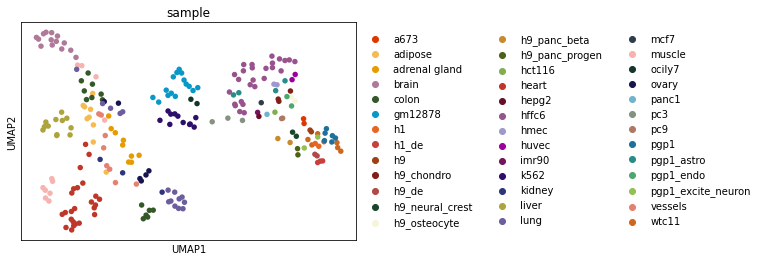

In [20]:
sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/sr_umap.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'sr_umap.pdf', dpi=500, bbox_inches='tight')

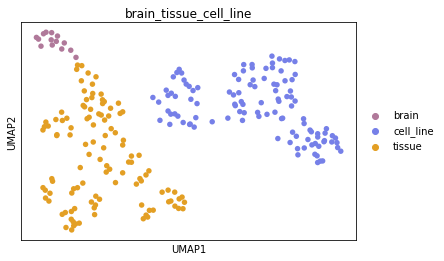

In [21]:
sc.pl.umap(adata, color='brain_tissue_cell_line', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/sr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'sr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')